# Helper Functions

## Packets

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sn
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.utils import from_networkx
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn.models import GNNExplainer
from torch_geometric.nn.conv import SAGEConv, GraphConv

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)
print(torch_geometric.__version__)
print(device)

1.11.0
2.0.4
cuda


## GNNs

In [2]:
class GNN7L_Sage (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, 16, aggr='max')
        self.conv2 = SAGEConv(16, 16, aggr='max')
        self.conv3 = SAGEConv(16, 16, aggr='max')
        self.conv4 = SAGEConv(16, 16, aggr='max')
        self.conv5 = SAGEConv(16, 16, aggr='max')
        self.conv6 = SAGEConv(16, 16, aggr='max')
        self.conv7 = SAGEConv(16, int(data.num_classes), aggr='max')

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv7(x, edge_index)

        return F.log_softmax(x, dim=1)

class GNN7L_GraphConv (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = GraphConv(data.num_features, 16, aggr='mean')
        self.conv2 = GraphConv(16, 16, aggr='mean')
        self.conv3 = GraphConv(16, 16, aggr='mean')
        self.conv4 = GraphConv(16, 16, aggr='mean')
        self.conv5 = GraphConv(16, 16, aggr='mean')
        self.conv6 = GraphConv(16, 16, aggr='mean')
        self.conv7 = GraphConv(16, int(data.num_classes), aggr='mean')

    def forward(self, x, edge_index):
        # x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv7(x, edge_index)

        return F.log_softmax(x, dim=1)

## Dataset Loader

In [3]:
# Dataset class: it allows to translate a vector (Graph, Attributes, Labels)
# into a dataset compatible with the PyTorch models.
# 
# Parameters:
# - G: NetworkX graph
# - labels: of the nodes used for classification
# - attributes: List of the nodes' attributes
# - num_classes: number of classes to classify

class MyDataset(InMemoryDataset):
  def __init__(self, G, labels, attributes, num_classes=2):
    super(MyDataset, self).__init__('.', None, None, None)

    # import data from the networkx graph with the attributes of the nodes
    data = from_networkx(G, attributes)
      
    y = torch.from_numpy(labels).type(torch.long)

    data.x = data.x.float()
    data.y = y.clone().detach()
    data.num_classes = num_classes

    # Using train_test_split function from sklearn to stratify train/test/val sets
    indices = range(G.number_of_nodes())
    # Stratified split of train/test/val sets. Returned indices are used to create the masks
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(data.x, data.y, indices, test_size=0.3, stratify=labels, random_state=42)
    # To create validation set, test set is splitted in half
    X_test, X_val, y_test, y_val, test_idx, val_idx = train_test_split(X_test, y_test, test_idx, test_size=0.5, stratify=y_test, random_state=42)

    n_nodes = G.number_of_nodes()
    train_mask  = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask   = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask    = torch.zeros(n_nodes, dtype=torch.bool)
    
    for idx in train_idx:
      train_mask[idx] = True

    for idx in test_idx:
      test_mask[idx] = True
    
    for idx in val_idx:
      val_mask[idx] = True

    data['train_mask']  = train_mask
    data['test_mask']   = test_mask
    data['val_mask']    = val_mask

    self.data, self.slices = self.collate([data])

## Classification Function

In [29]:
def show_results(data, output, classes):
    labels = data.y
    test_mask = data.test_mask

    print(classification_report(labels[test_mask].to('cpu'), output[test_mask].to('cpu')))

    #Confusion Matrix
    norms = [None, "true"]
    for norm in norms:
        cm = confusion_matrix(labels[test_mask].to('cpu'), output[test_mask].to('cpu'), normalize=norm)

        plt.figure(figsize=(7,7))
        
        if norm == "true":
            sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        else:
            sn.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

# model_name: 'CONV', 'SAGE'
# path: path to the saved model file
def GDAClassification(data, model_name, path):
    classes = None
    if data.num_classes == 2:
        classes = ['U', 'P']
    elif data.num_classes == 5:
        classes=['P', 'LP', 'WN', 'LN', 'RN']
    else:
        print('[ERR] Wrong number of classes. Number passed:', data.num_classes)
        return -1

    model = None
    if model_name == 'CONV':
        model = GNN7L_GraphConv(data).to(device)
    elif model_name == 'SAGE':
        model = GNN7L_Sage(data).to(device)
    else:
        print('[ERR] Wrong model name. Name passed:', model_name)
        return -1

    model.load_state_dict(torch.load(path))
    model.eval()
    logits = model(data.x, data.edge_index)
    output = logits.argmax(1)

    show_results(data, output, classes)
    
    return output, logits, model

# GDARanking

### Dataset creation function

In [5]:
def create_dataset(G, num_classes):

    labels = []

    if num_classes == 2:
        labels_df = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features.csv')
        labels_df = dict(zip(labels_df['name'], labels_df['class']))
        for node in G:
            labels.append(labels_df[node])

    elif num_classes == 5:
        seed_genes          = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_seed_genes.txt', header=None, sep=' ')
        seed_genes.columns  = ["name", "GDA Score"]
        seeds_list          = seed_genes["name"].values.tolist()

        nedbit_scores = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features_Score.csv')

        # Remove seed genes
        nedbit_scores_not_seed = nedbit_scores[~nedbit_scores['name'].isin(seeds_list)]

        # Sort scores for quartile division
        nedbit_scores_not_seed = nedbit_scores_not_seed.sort_values(by = "out", ascending = False)
        pseudo_labels = pd.qcut(x = nedbit_scores_not_seed["out"], q = 4, labels = ["RN", "LN", "WN", "LP"])

        nedbit_scores_not_seed['label'] = pseudo_labels

        nedbit_scores_seed = nedbit_scores[nedbit_scores['name'].isin(seeds_list)]
        nedbit_scores_seed = nedbit_scores_seed.assign(label = 'P')

        # Convert dataframe to dict for searching nodes and their labels
        not_seed_labels = dict(zip(nedbit_scores_not_seed['name'], nedbit_scores_not_seed['label']))
        seed_labels     = dict(zip(nedbit_scores_seed['name'], nedbit_scores_seed['label']))

        labels_dict = {'P':0, 'LP': 1, 'WN': 2, 'LN': 3, 'RN': 4}

        for node in G:
            if node in not_seed_labels:
                labels.append(labels_dict[not_seed_labels[node]])
            else:
                labels.append(labels_dict[seed_labels[node]])

    else:
        print('[ERR] Wrong number of classes. Number passed:', num_classes)
        return -1

    attributes = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']

    labels = np.asarray(labels)
    
    dataset_with_nedbit = MyDataset(G, labels, attributes, num_classes=num_classes)
    data_with_nedbit = dataset_with_nedbit[0]

    return data_with_nedbit

In [6]:
G = nx.read_gml('Graphs/graph_with_normalized_nedbit.gml')

## Binary

In [9]:
binary_data = create_dataset(G, 2).to(device)

### SAGE

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2810
           1       0.99      0.99      0.99       154

    accuracy                           1.00      2964
   macro avg       0.99      0.99      0.99      2964
weighted avg       1.00      1.00      1.00      2964



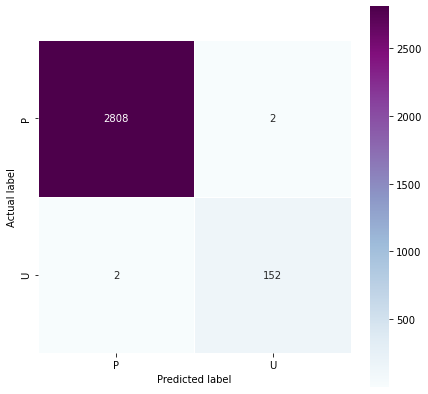

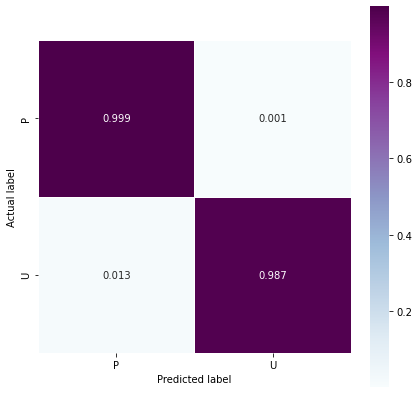

In [10]:
sage_preds_binary = GDAClassification(binary_data, 'SAGE', 'Models/SAGE7L_binary_16HC_v2_10000_0_0005')

### GraphCONV

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2810
           1       1.00      0.97      0.98       154

    accuracy                           1.00      2964
   macro avg       1.00      0.98      0.99      2964
weighted avg       1.00      1.00      1.00      2964



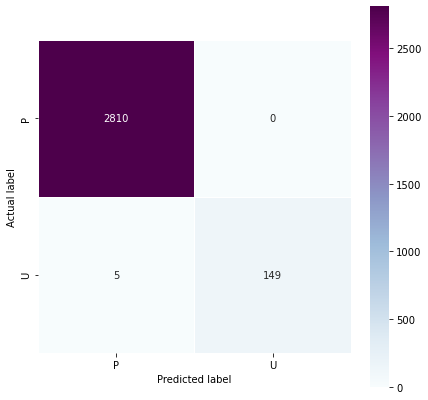

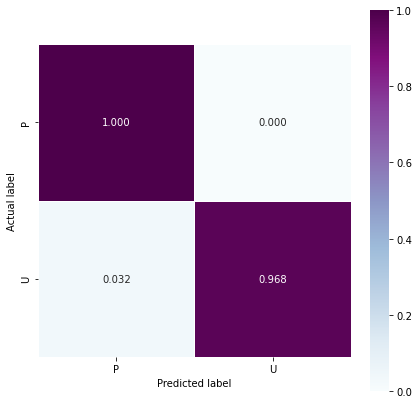

In [11]:
conv_preds_binary = GDAClassification(binary_data, 'CONV', 'Models/GraphConv7L_binary_16HC_v2_10000_0_0005')

## Multiclass

In [7]:
multiclass_data = create_dataset(G, 5).to(device)

### SAGE

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       154
           1       0.96      0.98      0.97       703
           2       0.88      0.94      0.91       702
           3       0.97      0.88      0.92       703
           4       0.99      1.00      1.00       702

    accuracy                           0.95      2964
   macro avg       0.96      0.96      0.96      2964
weighted avg       0.95      0.95      0.95      2964



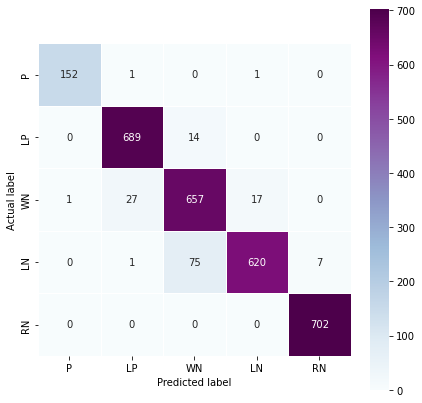

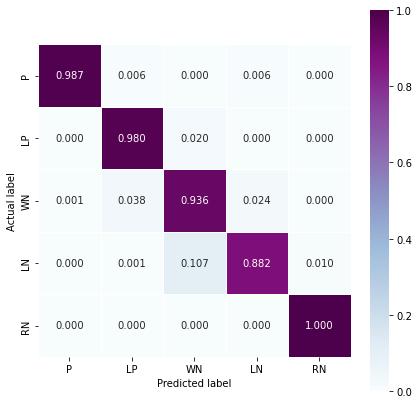

In [30]:
sage_pred_multi, sage_prob_multi, sage_model = GDAClassification(multiclass_data, 'SAGE', 'Models/SAGE7L_multiclass_16HC_v2_max_40000_0_0005')

### GraphCONV

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       154
           1       0.96      0.98      0.97       703
           2       0.91      0.93      0.92       702
           3       0.94      0.92      0.93       703
           4       0.99      1.00      0.99       702

    accuracy                           0.95      2964
   macro avg       0.94      0.92      0.93      2964
weighted avg       0.95      0.95      0.95      2964



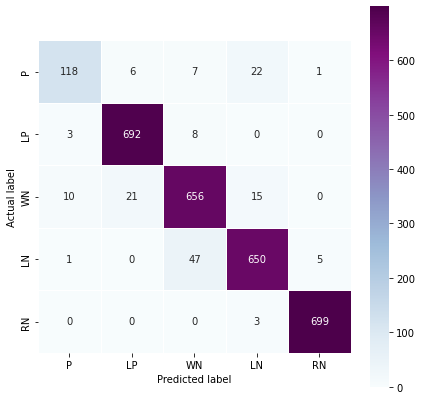

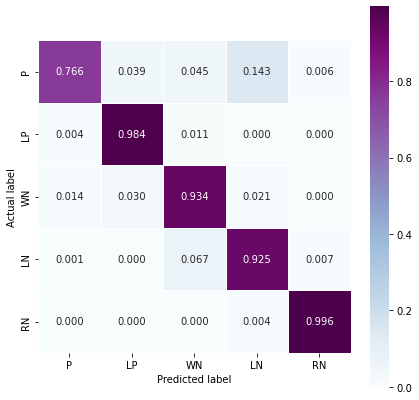

In [16]:
conv_preds_multi = GDAClassification(multiclass_data, 'CONV', 'Models/GraphConv7L_multiclass_16HC_v2_40000_0_0005')

## Explainabilty

In [35]:
# Predicted P(ositive) genes in the test mask
# dictionaries with {gene: prob}
test_P      = {}
overall_LP  = {}

test_mask = multiclass_data.test_mask
test_preds = sage_pred_multi[test_mask]
test_probs = sage_prob_multi[test_mask]

test_nodes = []
i = 0
for node in G.nodes:
    if test_mask[i]:
        test_nodes.append(node)
    if sage_pred_multi[i] == 1 and node not in overall_LP:
        overall_LP[node] = sage_prob_multi[i][1].item() # take probability of class 1 (LP)
    i += 1

i = 0
for node in test_nodes:
    if test_preds[i] == 0 and node not in test_P: #P
        test_P[node] = test_probs[i][0].item() # take probability of class 0 (p)
    i += 1

print('# of predicted positive genes in test mask:', len(test_P))
print('# of predicted overall likely positive genes:', len(overall_LP))

# of predicted positive genes in test mask: 153
# of predicted overall likely positive genes: 4729


In [45]:
import heapq

top_ten_test_P = heapq.nlargest(10, test_P, key=test_P.get)
top_ten_test_P

['CTNNB1',
 'RB1',
 'C1QBP',
 'KRT8',
 'AKT1',
 'FLT1',
 'PDZK1',
 'CDKN2A',
 'FASN',
 'XRCC2']

In [48]:
# list of positive genes indexes in test_mask
top_ten_test_P_idx = []

for node in top_ten_test_P:
    i = 0
    for n in G.nodes:
        if node == n:
            top_ten_test_P_idx.append(i)
            break
        i += 1

top_ten_test_P_idx

[54, 55, 178, 213, 287, 306, 395, 596, 610, 641]

In [54]:
edge_index = multiclass_data.edge_index

for i in top_ten_test_P_idx:
    subg_nodes, subg_edge_index, subg_mapping, subg_edge_mask = torch_geometric.utils.k_hop_subgraph(i, 1, edge_index)
    print(i, len(subg_nodes), subg_edge_index.shape)


54 802 torch.Size([2, 55232])
55 273 torch.Size([2, 6558])
178 690 torch.Size([2, 45072])
213 353 torch.Size([2, 9052])
287 458 torch.Size([2, 15500])
306 25 torch.Size([2, 132])
395 58 torch.Size([2, 330])
596 272 torch.Size([2, 7926])
610 917 torch.Size([2, 35448])
641 24 torch.Size([2, 104])


Explain node 641: 100%|██████████| 200/200 [00:01<00:00, 103.20it/s]


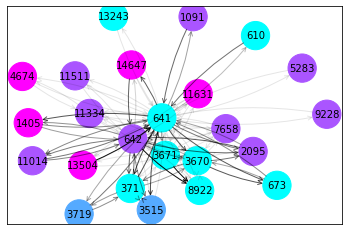

In [55]:
x = multiclass_data.x
y = multiclass_data.y
edge_index = multiclass_data.edge_index

explainer = GNNExplainer(sage_model, epochs=200, return_type='log_prob', num_hops=1)
node_idx = 641 #node to explain
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G_exp = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=y)
plt.show()

In [20]:
edge_mask

  0%|          | 0/1357864 [00:00<?, ?it/s]

8